In [4]:
# import the libraries as shown below
import keras
from keras import backend as K
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'


In [26]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [27]:
for layer in vgg.layers:
    layer.trainable = False

In [28]:
# useful for getting number of output classes
folders = glob('Datasets/train/*')

In [32]:
x= Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [33]:
# view the structure of the model
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [34]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [35]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [36]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [37]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [39]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
163/163 [==============================] - 635s 4s/step - loss: 0.1178 - accuracy: 0.9540 - val_loss: 0.2315 - val_accuracy: 0.9151
Epoch 2/10
163/163 [==============================] - 778s 5s/step - loss: 0.1142 - accuracy: 0.9582 - val_loss: 0.3417 - val_accuracy: 0.9087
Epoch 3/10
163/163 [==============================] - 715s 4s/step - loss: 0.0881 - accuracy: 0.9674 - val_loss: 0.3028 - val_accuracy: 0.9135
Epoch 4/10
163/163 [==============================] - 876s 5s/step - loss: 0.0815 - accuracy: 0.9691 - val_loss: 0.3194 - val_accuracy: 0.9199
Epoch 5/10
163/163 [==============================] - 877s 5s/step - loss: 0.0642 - accuracy: 0.9751 - val_loss: 0.2885 - val_accuracy: 0.9199
Epoch 6/10
163/163 [==============================] - 841s 5s/step - loss: 0.0721 - accuracy: 0.9726 - val_loss: 0.6284 - val_accuracy: 0.8702
Epoch 7/10
163/163 [==============================] - 882s 5s/step - loss: 0.0694 - accuracy: 0.9758 - val_loss: 0.2724 - val_accuracy: 0.9167

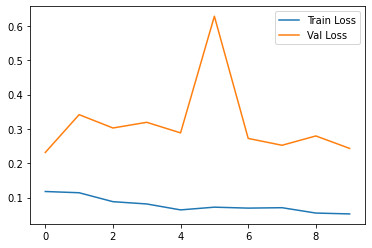

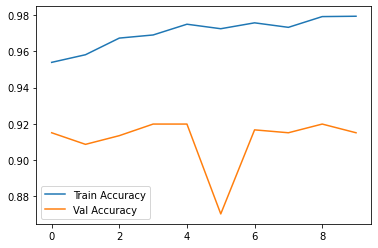

<Figure size 432x288 with 0 Axes>

In [40]:
# plot the loss
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
fig_loss = plt.gcf()
plt.show()
plt.draw()
fig_loss.savefig('Val Loss.png', dpi=100)

# plot the accuracy
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Val Accuracy')
plt.legend()
fig_acc = plt.gcf()
plt.show()
plt.draw()
fig_acc.savefig('Val Accuracy.png', dpi=100)

In [41]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')

In [11]:
image_size = 224
test_dir = 'Datasets/test'
test_batchsize = 10

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

vgg16_model = load_model('model_vgg16.h5')
Y_pred = vgg16_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('\nClassification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Found 620 images belonging to 2 classes.
Confusion Matrix
[[210  24]
 [ 29 357]]

Classification Report
              precision    recall  f1-score   support

      Normal       0.88      0.90      0.89       234
   Pneumonia       0.94      0.92      0.93       386

    accuracy                           0.91       620
   macro avg       0.91      0.91      0.91       620
weighted avg       0.91      0.91      0.91       620



In [ ]:
#VGG19

In [4]:

# vgg19 attempt
from keras.applications.vgg19 import VGG19

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

vgg2 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
for layer in vgg2.layers:
    layer.trainable = False

from glob import glob
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

folders = glob('Datasets/train/*')



In [6]:

z= Flatten()(vgg2.output)
prediction2 = Dense(len(folders), activation='softmax')(z)
# create a model object
models = Model(inputs=vgg2.input, outputs=prediction2)

models.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [7]:
# tell the model what cost and optimization method to use
models.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [8]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [10]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [11]:
# fit the model
r = models.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
163/163 [==============================] - 881s 5s/step - loss: 0.2135 - accuracy: 0.9191 - val_loss: 0.2939 - val_accuracy: 0.8942
Epoch 2/5
163/163 [==============================] - 905s 6s/step - loss: 0.1215 - accuracy: 0.9526 - val_loss: 0.2673 - val_accuracy: 0.9071
Epoch 3/5
163/163 [==============================] - 827s 5s/step - loss: 0.1391 - accuracy: 0.9469 - val_loss: 0.2784 - val_accuracy: 0.9087
Epoch 4/5
163/163 [==============================] - 790s 5s/step - loss: 0.1389 - accuracy: 0.9463 - val_loss: 0.2643 - val_accuracy: 0.9215
Epoch 5/5
163/163 [==============================] - 775s 5s/step - loss: 0.1052 - accuracy: 0.9605 - val_loss: 0.2592 - val_accuracy: 0.9199


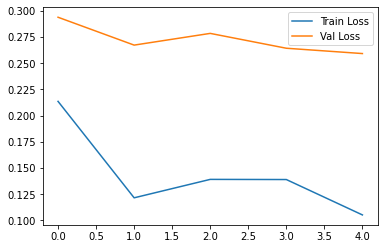

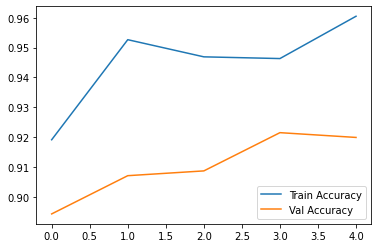

<Figure size 432x288 with 0 Axes>

In [12]:
# plot the loss
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
fig_loss = plt.gcf()
plt.show()
plt.draw()
fig_loss.savefig('Val Loss2.png', dpi=100)

# plot the accuracy
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Val Accuracy')
plt.legend()
fig_acc = plt.gcf()
plt.show()
plt.draw()
fig_acc.savefig('Val Accuracy2.png', dpi=100)

In [23]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

models.save('model_vgg19.h5')

In [26]:
image_size = 224
test_dir = 'Datasets/test'
test_batchsize = 10

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

vgg16_model = load_model('model_vgg19.h5')
Y_pred = vgg16_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('\nClassification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Found 620 images belonging to 2 classes.


OSError: SavedModel file does not exist at: model_vgg19.h5/{saved_model.pbtxt|saved_model.pb}

In [2]:
# RESNET 50

In [14]:

# vgg19 attempt
from tensorflow.keras.applications.resnet50 import ResNet50

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

resn = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [15]:
for layer in resn.layers:
    layer.trainable = False

from glob import glob
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

folders = glob('Datasets/train/*')

In [16]:
y= Flatten()(resn.output)
prediction3 = Dense(len(folders), activation='softmax')(y)
# create a model object
modelss = Model(inputs=resn.input, outputs=prediction3)

modelss.summary()

0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]    

In [17]:
modelss.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 620 images belonging to 2 classes.


In [21]:
# fit the model
r = modelss.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
163/163 [==============================] - 316s 2s/step - loss: 0.7329 - accuracy: 0.7826 - val_loss: 0.3875 - val_accuracy: 0.8484
Epoch 2/5


KeyboardInterrupt: 

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
fig_loss = plt.gcf()
plt.show()
plt.draw()
fig_loss.savefig('Val Loss3.png', dpi=100)

# plot the accuracy
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Val Accuracy')
plt.legend()
fig_acc = plt.gcf()
plt.show()
plt.draw()
fig_acc.savefig('Val Accuracy3.png', dpi=100)

In [ ]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

modelss.save('model_resnet.h5')

In [25]:
image_size = 224
test_dir = 'Datasets/test'
test_batchsize = 10

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

vgg16_model = load_model('model_resnet.h5')
Y_pred = vgg16_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('\nClassification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Found 620 images belonging to 2 classes.
Confusion Matrix
[[207  27]
 [ 84 302]]

Classification Report
              precision    recall  f1-score   support

      Normal       0.71      0.88      0.79       234
   Pneumonia       0.92      0.78      0.84       386

    accuracy                           0.82       620
   macro avg       0.81      0.83      0.82       620
weighted avg       0.84      0.82      0.82       620

